<a href="https://colab.research.google.com/github/dxbezerra/tvdi/blob/master/TVDI_projeto_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto TVDI**

Autores: Diego, Raíssa, Stella, Gustavo

Disciplina de Introdução à Programação (SER-307)

Instituto Nacional de Pesquisas Espaciais (INPE)


---
Objetido: Operacionalizar o monitoramento de seca agrícola para uma região em determinado período através do sensoriamento remoto

Temperature-Vegetation Dryness Index (TVDI) proposto por Sandholt et al. (2002).

In [1]:
# Limpar dados, instalar bibliotecas e fazer download do shapefile
!rm -rf sample_data
!rm -rf processed
!pip install pymodis
!git clone https://github.com/dxbezerra/tvdi.git

# Importar módulos
import gdal
from gdalconst import *
import numpy as np
from glob import glob
import scipy
from os import path as osp
import os, calendar, itertools, sys, subprocess
from pymodis import downmodis
from pymodis.convertmodis_gdal import convertModisGDAL
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

     |████████████████████████████████| 2.6MB 2.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/6a/8c/b2/ddf2b77df1137a05b5643e31e0ef745319fa86e299a27aaec8
Successfully built pymodis
Cloning into 'tvdi'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 34 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (34/34), done.
WxPython missing, no GUI enabled


In [2]:
# Criar diretório dos dados
path = './raw_data'
if not osp.exists(path):
    os.mkdir(path)
print(os.listdir('./'))

['.config', 'tvdi', 'raw_data']


# **1. Download das imagens**
A partir da biblioteca pyModis realizamos o download das imagens de interesse. No caso, utilizamos o produto MOD13A2 que corresponde ao índices de vegetação NDVI e EVI composto de 16 dias e o produto MOD11A2 correspondente a Temperature Superficial do Solo (TS) para de um intervalo de 8 dias.
O período analisado é referente ao dia juliano 257 (segunda quinzena de Setembro), que é o período mais seco no Estado do Ceará.

In [3]:
# Usuário e senha Earthdata
user     = 'grupo_tvdi'
password = 'Ninguempodesaber1'

# Cenas e produtos a serem baixados
tiles    = 'h14v09','h13v09'
products = ['MOD13A2.006', 'MOD11A2.006']

# Período selecionado
day     = '2018-09-14'
enddate = '2018-09-29'

# Download
print('Realizando download...')

for p in products:
  modisDown = downmodis.downModis(destinationFolder=path,
  password=password, user=user, tiles=tiles, product=p, today=day,
  enddate=enddate)

  modisDown.connect()
  modisDown.downloadsAllDay()

print('Download completo.')

# Checkar imagens baixadas e o seu tamanho em megabytes
fls = sorted(glob(path + '/*.hdf'))
for f in fls:
  print(osp.basename(f),'-', osp.getsize(f)/10e5, 'MB')

Realizando download...
Download completo.
MOD11A2.A2018257.h13v09.006.2018266035239.hdf - 6.701147 MB
MOD11A2.A2018257.h14v09.006.2018266035104.hdf - 3.322762 MB
MOD11A2.A2018265.h13v09.006.2018282164825.hdf - 6.699373 MB
MOD11A2.A2018265.h14v09.006.2018282165559.hdf - 3.339318 MB
MOD13A2.A2018257.h13v09.006.2018282125001.hdf - 19.171178 MB
MOD13A2.A2018257.h14v09.006.2018282125732.hdf - 7.887101 MB


# **2. Extrair bandas de interesse das imagens**
Tendo em vista que as imagens MODIS são contidas de diversas bandas (ex.: banda de qualidade do pixel, presença de nuvens, ângulo solar zenital, etc.), as bandas de interesse  são primeiramente extraídas com o módulo *convertModisGDAL*. Para o produto MOD13A2 utilizamos o NDVI e para o produto MOD11A2 a banda utilizada é a do TS capturado durante o dia (*LST_Day_1km*), ambos sendo a primeira banda.

In [4]:
# Selecionar as datas julianas únicas das imagens baixadas (np.unique seleciona apenas valores que não se repetem)
juliandays = np.unique([osp.basename(f).split(".")[1][-3:] for f in fls])

# Diretório de saída das bandas
path = './processed'
if not osp.exists(path):
  os.mkdir(path)

# Extrair bandas  
for f in fls:
  
  # Banda selecionada (Seleciona somente a primeira banda)
  subset = "1"
  
  # Extrair bandas com pymodis (obs: epsg é o código de reprojeção da imagem)
  fileout = osp.join(path, osp.basename(f)[:-4])
  extr = convertModisGDAL(f, fileout, subset, res=None, outformat='GTiff', epsg=4326)
  extr.run(quiet=True)
   
# Checkar bandas extraídas
fls = sorted(glob(path + '/*.tif'))
for f in fls:
  print(osp.basename(f))

MOD11A2.A2018257.h13v09.006.2018266035239_LST_Day_1km.tif
MOD11A2.A2018257.h14v09.006.2018266035104_LST_Day_1km.tif
MOD11A2.A2018265.h13v09.006.2018282164825_LST_Day_1km.tif
MOD11A2.A2018265.h14v09.006.2018282165559_LST_Day_1km.tif
MOD13A2.A2018257.h13v09.006.2018282125001_1 km 16 days NDVI.tif
MOD13A2.A2018257.h14v09.006.2018282125732_1 km 16 days NDVI.tif


#**3. Mosaicagem**
As imagens baixadas são correspondentes às cenas do MODIS (h14v09 e h13v09) e necessitam que sejam combinadas para o Estado do Ceará. Esse processo é realizado selecionando as imagens de mesmo produto e período, porém de cenas distintas. Mais adiante o GDAL é utilizado para criar o mosaico.

In [5]:
# Listas
products   = ['MOD13A2.006', 'MOD11A2.006']
juliandays = np.unique([osp.basename(f).split(".")[1][-3:] for f in fls])

# Selecionar imagens de mesmo produto e período, porém de cenas distintas
for p in products:
  p = p.split(".")[0]
  
  for jd in juliandays:

    # Selecionar todas as imagens criadas no passo anterior (bandas extraídas) para o mesmo produto
    glb = glob('./processed/{0}*.tif'.format(p))

    # Guardar imagens de cenas distintas de mesmo produto e de mesmo período em uma lista
    pair = []
    for im in glb:
      if jd in im:
        pair.append(im)
    
    # Se a lista de imagens não for vazia, prosseguir.
    if not pair == []:
    
      # Remover espaços no nome do arquivo (pra não dar problema com o GDAL)
      rm_spaces = pair[0].replace(" ", "")
      
      # Criar um novo nome para arquivo de saída
      fname = rm_spaces[:-4] + ".MOSAIC.vrt"

      # Criar mosaico com o GDAL utilizando o shell
      gdal.BuildVRT(fname, pair)
      translateCmd = 'gdal_translate -of GTiff {0} {1}.tif'.format(fname, fname[:-4])
      subprocess.call(translateCmd, shell=True)

# Checkar mosaicos criados
fls = sorted(glob(path + '/*MOSAIC.tif'))
for f in fls:
  print(osp.basename(f))

MOD11A2.A2018257.h13v09.006.2018266035239_LST_Day_1km.MOSAIC.tif
MOD11A2.A2018265.h14v09.006.2018282165559_LST_Day_1km.MOSAIC.tif
MOD13A2.A2018257.h14v09.006.2018282125732_1km16daysNDVI.MOSAIC.tif


# **4. Recorte para área de interesse**
Para focarmos somente na área de nosso interesse, realizamos um recorte utilizando o arquivo *shapefile* dos limites estaduais do Ceará, evitando assim o processamento de dados irrelevantes posteriormente.

In [6]:
# Arquivo shapefile
shp = './tvdi/ce.shp'
print(os.path.isfile(shp))

# Realizar corte a partir dos mosaico da pasta dos arquivos processados
for f in fls:
  
  # Nome do arquivo da imagem recortada
  fname = f[:-4] + ".CLIP.tif"

  # Realizar recorte com gdalwarp utilizando o shell
  warpCmd = 'gdalwarp -dstnodata -3000 -cutline {0} {1} {2}\
            -crop_to_cutline -overwrite'.format(shp, f, fname)
  subprocess.call(warpCmd, shell=True)

# Checkar recortes criados
fls = sorted(glob(path + '/*CLIP.tif'))
for f in fls:
  print(osp.basename(f))

True
MOD11A2.A2018257.h13v09.006.2018266035239_LST_Day_1km.MOSAIC.CLIP.tif
MOD11A2.A2018265.h14v09.006.2018282165559_LST_Day_1km.MOSAIC.CLIP.tif
MOD13A2.A2018257.h14v09.006.2018282125732_1km16daysNDVI.MOSAIC.CLIP.tif


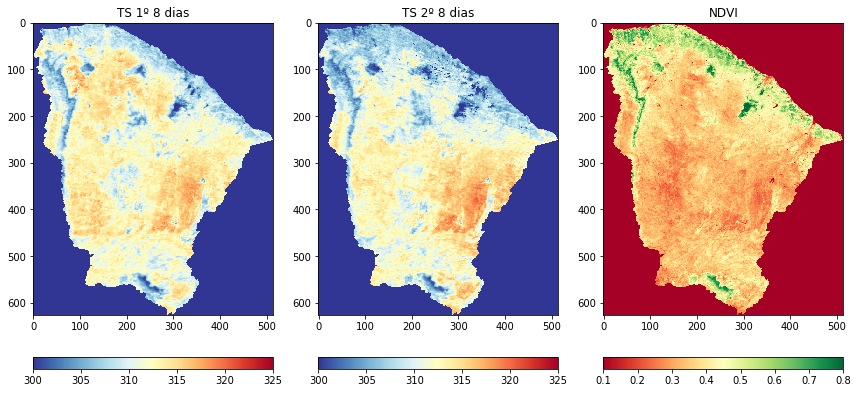

In [7]:
# Plot das imagens recortadas
dset_tss1, dset_tss2, dset_ndvi = gdal.Open(fls[0], GA_ReadOnly),\
                                  gdal.Open(fls[1], GA_ReadOnly),\
                                  gdal.Open(fls[2], GA_ReadOnly)

tss1_band, tss2_band, ndvi_band = dset_tss1.GetRasterBand(1),\
                                  dset_tss2.GetRasterBand(1),\
                                  dset_ndvi.GetRasterBand(1)

plt.figure(figsize=(12, 12))

plt.subplot(131)
plt.title("TS 1º 8 dias")
plt.imshow(tss1_band.ReadAsArray() * 0.02, cmap='RdYlBu_r', vmin=300, vmax=325)
plt.colorbar(orientation="horizontal", pad=0.05)

plt.subplot(132)
plt.title("TS 2º 8 dias")
plt.imshow(tss2_band.ReadAsArray() * 0.02, cmap='RdYlBu_r', vmin=300, vmax=325)
plt.colorbar(orientation="horizontal", pad=0.05)

plt.subplot(133)
plt.title("NDVI")
plt.imshow(ndvi_band.ReadAsArray() * 0.0001, cmap='RdYlGn', vmin=0.1, vmax=0.8)
plt.colorbar(orientation="horizontal", pad=0.05)

plt.tight_layout(pad=1)
plt.show()

dset_tss1, dset_tss2, dset_ndvi = None, None, None

# **5. Acessar imagens**
Para igualar o período observado entre as imagens de NDVI e TS, nesta seção é realizada uma média temporal das duas imagens TS de 8 dias. 

In [0]:
fls = sorted(glob(path + '/*CLIP.tif'))

# Carregar imagens de temperatura
dset_tss1 = gdal.Open(fls[0], GA_ReadOnly)
dset_tss2 = gdal.Open(fls[1], GA_ReadOnly)

dset_tss1_band = dset_tss1.GetRasterBand(1)
dset_tss2_band = dset_tss2.GetRasterBand(1)

# Multiplicar pelo fator de escala
dset_tss1_array = dset_tss1_band.ReadAsArray() * 0.02
dset_tss2_array = dset_tss2_band.ReadAsArray() * 0.02

# Criar máscara (substituir np.nan para valores de 0, que são os valores inválidos)
dset_tss1_array[dset_tss1_array == 0] = np.nan
dset_tss2_array[dset_tss2_array == 0] = np.nan

# Calcular média temporal ignorando nan
stack_2d = np.array([dset_tss1_array, dset_tss2_array])
TS      = scipy.nanmean(stack_2d, axis=0) # média: 311.56830648359954

# Fechar datasets
dset_tss1, dset_tss2 = None, None

# Arredondar para duas casas decimais e printar valor médio de TS
TS = np.round(TS, 2)

O acesso à imagem de NDVI segue da seguinte forma:

In [0]:
# Carregar imagem de NDVI
dset_ndvi = gdal.Open(fls[2], GA_ReadOnly)
ndvi_band = dset_ndvi.GetRasterBand(1)
gt        = dset_ndvi.GetGeoTransform()

# Multiplicar pelo fator de escala
NDVI      = ndvi_band.ReadAsArray() * 0.0001

# Criar máscara (substituir np.nan para valores de 0, que são os valores inválidos)
NDVI[NDVI == -0.3] = np.nan

# Fechar dataset
dset_ndvi = None

# Arredondar para duas casas decimais e printar valor médio de NDVI
NDVI = np.round(NDVI, 2)

Visualização das imagens escaladas e histogramas:

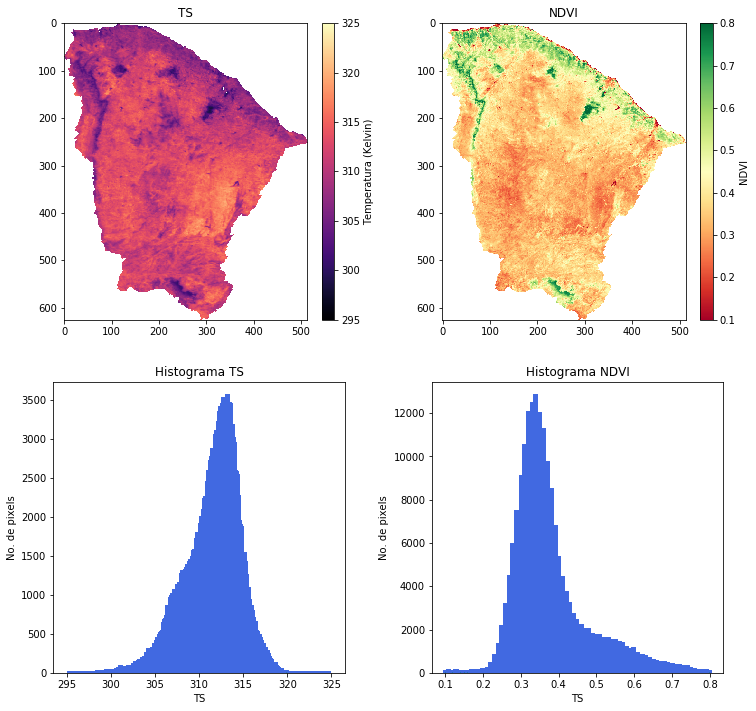

In [10]:
# Tamanho do plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
plt.subplots_adjust(left=0.125, right = 0.9, wspace=0.3)

# Subplot TS
img1 = ax1.imshow(TS, cmap='magma', vmin=295, vmax=325)
ax1.set_title("TS")
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(img1, cax=cax1)
cbar.set_label("Temperatura (Kelvin)")

# Subplot NDVI
img2 = ax2.imshow(NDVI, cmap='RdYlGn', vmin=0.1, vmax=0.8)
ax2.set_title("NDVI")
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(img2, cax=cax2)
cbar.set_label("NDVI")

# Subplot Histograma TS
img3 = ax3.hist(TS.ravel(), bins=256, range=(295, 325), lw=4, ec='royalblue')
ax3.set_aspect(1./ax3.get_data_ratio())
ax3.set_title("Histograma TS")
ax3.set_xlabel('TS')
ax3.set_ylabel('No. de pixels')

# Subplot Histograma NDVI
img4 = ax4.hist(NDVI.ravel(), bins=256, range=(0.1, 0.8), lw=4, ec='royalblue')
ax4.set_aspect(1./ax4.get_data_ratio())
ax4.set_title("Histograma NDVI")
ax4.set_xlabel('TS')
ax4.set_ylabel('No. de pixels')

# Remover bordas da figura
fig.show()

# **6. Tratamento dos dados**
Antes da extração do TVDI, os valores de TS fora de 3 desvios padrões foram removidos para melhor representação dos limiares úmido e seco. Além disso, os valores de NDVI menores que zero foram eliminados pois tendem a ser representativos de corpos d'àgua.

Eliminar outliers

In [11]:
# Retirar valores fora de 3 desvios padrões da imagem de TS
std  = np.nanstd(TS) # desvio padrão
mean = np.nanmean(TS) # média

lower_limit = mean - (std*3)
upper_limit = mean + (std*3)

np.where(TS, TS < lower_limit, np.nan)
np.where(TS, TS > upper_limit, np.nan)

print("Limiar mínimo:", np.nanmin(TS), "K")
print("Limiar máximo:", np.nanmax(TS), "K")

# Retirar valores menores que zero na imagem de NDVI
NDVI[NDVI < 0] = np.nan

Limiar mínimo: 298.25 K
Limiar máximo: 320.41 K


# **7. Cálculo das retas**
COLOCAR FIGURINHA DO TVDI AQUI

Para o cálculo das retas, primeiramente são determinadas as temperaturas correspondentes ao mesmo valor de NDVI. Então são estabelecidas as temperaturas máxima e mínima para cada NDVI.

Retirada dos valores máximos e mínimos de TS

In [12]:
# Listas para mínimos (limite úmido) e máximos de TS (limite seco)
MiniList    = []
MaxList     = []
# Criar um vetor de NDVI (0 a 1 com espaçamento de 0.01)
NDVI_vector = np.round(np.arange(0.01, 1.01, 0.01), 2)

# Primeiramente são encontrados os valores de TS para mesmo NDVI
for val in NDVI_vector:
  TS_vector_val = []
  row, col = np.where(NDVI == val) # extrair index
  
  # Com a localização destes NDVIs, retiramos os valores de temperatura
  # correspondentes a estas posições (linhas e colunas)
  for i in range(len(row)):
    if np.isfinite(TS[row[i], col[i]]):
      TS_vector_val += [TS[row[i], col[i]]]
  
  # Se houver valores de TS para o NDVI desejado, é retirado os
  # valores máximo e mínimo
  if TS_vector_val != []:
    TS_min_val = np.min(TS_vector_val)
    TS_max_val = np.max(TS_vector_val)
  else:
    TS_min_val = np.nan
    TS_max_val = np.nan

  # Os valores encontrados são adicionados na listas MiniList e MaxList
  MiniList += [TS_min_val]
  MaxList  += [TS_max_val]
  
print("Valores mínimos", "- len:", len(MiniList))
print(MiniList)
print("Valores máximos", "- len:", len(MaxList))
print(MaxList)
print("Valores de NDVI", "- len:", len(NDVI_vector))
print(list(NDVI_vector))

Valores mínimos - len: 100
[299.44, 304.72, 304.92, 304.71, 301.12, 301.6, 299.56, 302.83, 299.72, 300.89, 303.9, 301.11, 301.23, 300.72, 303.98, 300.31, 301.45, 302.83, 301.96, 300.92, 301.62, 301.02, 302.3, 301.13, 302.53, 301.02, 302.35, 301.17, 302.74, 301.63, 298.77, 302.84, 301.0, 302.51, 301.12, 300.45, 302.13, 299.98, 300.4, 301.1, 302.32, 302.78, 301.14, 301.68, 302.22, 301.17, 300.86, 300.62, 301.55, 301.05, 299.92, 301.21, 301.26, 301.37, 299.98, 301.08, 300.11, 301.37, 300.13, 299.22, 301.8, 300.4, 300.35, 300.08, 301.11, 300.32, 299.72, 300.03, 299.56, 300.81, 299.86, 299.01, 298.93, 299.56, 299.66, 299.96, 299.43, 299.82, 299.02, 299.8, 298.34, 298.73, 298.47, 299.03, 298.45, 298.59, 298.25, 299.0, nan, nan, 302.05, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Valores máximos - len: 100
[306.25, 305.82, 309.67, 307.07, 310.56, 307.73, 309.76, 311.21, 311.49, 314.41, 313.03, 311.18, 312.75, 309.64, 312.94, 314.41, 317.82, 315.77, 318.03, 318.65, 319.66, 319.64, 320.19, 320

Retirar coeficientes *a* e *b* para cálculo do TVDI

In [13]:
#LimiteMax = np.polyfit(NDVI_vector, MaxList, 1)
#LimiteMin = np.polyfit(NDVI_vector, MiniList, 1)
#print(LimiteMax)


# Reta minimo
MiniList_fin = []
NDVI_fin = []

for i, val in enumerate(MiniList):
  if np.isfinite(val):
    MiniList_fin += [val]
    NDVI_fin += [NDVI_vector[i]]
print(MiniList_fin)
print(NDVI_fin)

MinPfit = np.polyfit(NDVI_fin[17:], MiniList_fin[17:], 1)
print(MinPfit)

# Reta maximo
MaxList_fin = []
NDVI_fin = []
for i, val in enumerate(MaxList):
  if np.isfinite(val):
    MaxList_fin += [val]
    NDVI_fin += [NDVI_vector[i]]
print(MaxList_fin)
print(NDVI_fin)


MaxPfit = np.polyfit(NDVI_fin[17:], MaxList_fin[17:], 1)
print(MaxPfit)

[299.44, 304.72, 304.92, 304.71, 301.12, 301.6, 299.56, 302.83, 299.72, 300.89, 303.9, 301.11, 301.23, 300.72, 303.98, 300.31, 301.45, 302.83, 301.96, 300.92, 301.62, 301.02, 302.3, 301.13, 302.53, 301.02, 302.35, 301.17, 302.74, 301.63, 298.77, 302.84, 301.0, 302.51, 301.12, 300.45, 302.13, 299.98, 300.4, 301.1, 302.32, 302.78, 301.14, 301.68, 302.22, 301.17, 300.86, 300.62, 301.55, 301.05, 299.92, 301.21, 301.26, 301.37, 299.98, 301.08, 300.11, 301.37, 300.13, 299.22, 301.8, 300.4, 300.35, 300.08, 301.11, 300.32, 299.72, 300.03, 299.56, 300.81, 299.86, 299.01, 298.93, 299.56, 299.66, 299.96, 299.43, 299.82, 299.02, 299.8, 298.34, 298.73, 298.47, 299.03, 298.45, 298.59, 298.25, 299.0, 302.05]
[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0

Visualizar gráfico de dispersão

Text(0.5, 1.0, 'NDVI vs TS Scatterplot')

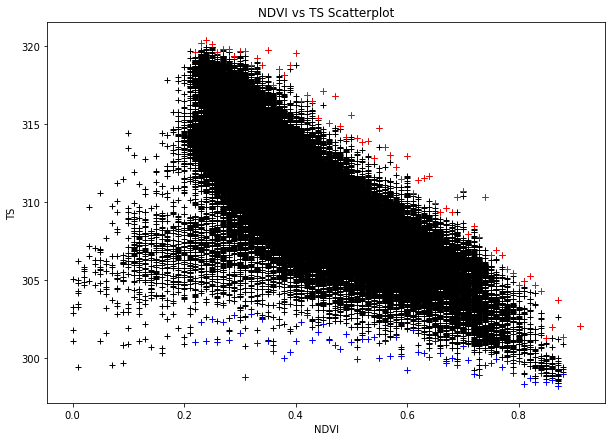

In [14]:
from scipy.stats import gaussian_kde

# FALTA: Plotar retas

# Retirar os valores
# # plt.subplot(131)
# plt.plot(NDVI_vector[21:], MiniList[21:], '+', color='b')
# plt.plot(NDVI_vector[21:], MaxList[21:], '+', color='r')

plt.figure(figsize=(10,7))
plt.plot(NDVI.ravel(), TS.ravel(), "+", color='black')#, markersize=3)
plt.plot(NDVI_vector[21:], MiniList[21:], '+', color='b')
plt.plot(NDVI_vector[21:], MaxList[21:], '+', color='r')

plt.xlabel("NDVI")
plt.ylabel("TS")
plt.title("NDVI vs TS Scatterplot")

# NDVI_finite = NDVI.ravel()[~np.isnan(NDVI.ravel())]
# TS_finite  = TS.ravel()[~np.isnan(TS.ravel())]
# xy = np.vstack([NDVI_finite, TS_finite])
# z = gaussian_kde(xy)(xy)

# fig, ax = plt.subplots()
# ax.scatter(x, y, c=z, s=100, edgecolor='')
# plt.show()

# **8. Cálculo do TVDI**

![TVDI](https://docs.google.com/uc?export=download&id=1nh-vaYSW5A-g5N2uour3zTiABSmvv86z)

Cálculo

In [15]:
#TVDI = np.full(shape[0], shape[1], np.nan)

a1, b1 = MaxPfit
a2, b2 = MinPfit
print(a1,b1)
print(a2,b2)

Ts_max = b1 + (a1 * NDVI)
Ts_min = b2 + (a2 * NDVI)

TVDI = (TS - Ts_min) / (Ts_max - Ts_min)

# for ii in range(NDVI.shape[0]):
#   for jj in range(NDVI.shape[1]):
#     TVDI[ii, jj] = (TS)

print(np.nanmin(TVDI))
print(np.nanmax(TVDI))

-26.12401869873436 326.9755511201281
-4.286595980376457 302.9153529039404
-0.18492313115364323
1.338740698205988


Plotar imagem de TVDI

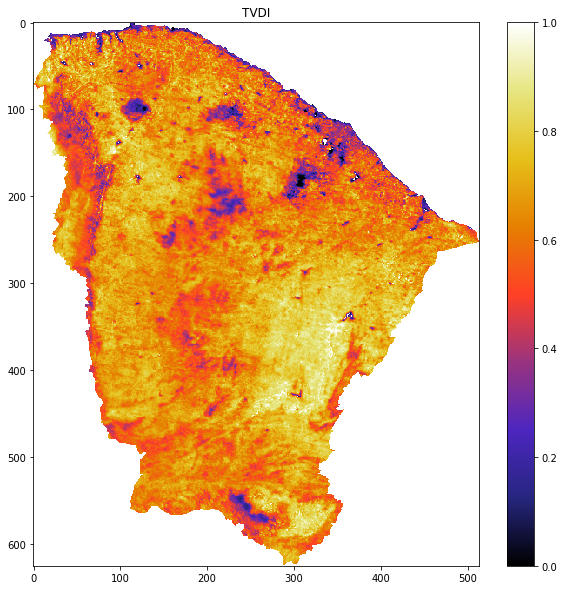

In [16]:
# proximo a 1 é seco e proximo a 0 é umido
plt.figure(figsize=(10, 10))

plt.imshow(TVDI, cmap='CMRmap', vmin=0, vmax=1)
plt.title("TVDI")

plt.colorbar(orientation="vertical", pad=0.05)


Text(0, 0.5, 'No. de pixels')

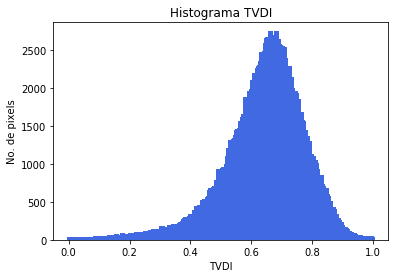

In [17]:
plt.hist(TVDI.ravel(), bins=256, range=(0, 1), lw=4, ec='royalblue')
plt.title("Histograma TVDI")
plt.xlabel('TVDI')
plt.ylabel('No. de pixels')

Salvar imagem de TVDI em formato GeoTIFF



In [18]:
# gt = dset_ndvi.GetGeoTransform()

print("Geotransform:", gt)

# lat lon arrays
x = np.linspace(gt[0], gt[0] + gt[1] * NDVI.shape[1], NDVI.shape[1])
y = np.linspace(gt[3], gt[3] + gt[5] * NDVI.shape[0], NDVI.shape[0])

#print(x)
#print(y)

xx, yy = np.meshgrid(x, y)
print(xx.shape, yy.shape)


fname = "./crop-1-ndvi-threshold.tif"
driver = gdal.GetDriverByName('GTiff')


Geotransform: (-41.423518008999984, 0.00811328187548637, 0.0, -2.784230650091664, 0.0, -0.008105354346907763)
(626, 514) (626, 514)


In [19]:
# obter metadados
linhas = dataset_crop_1_band_5.RasterYSize
colunas = dataset_crop_1_band_5.RasterXSize
bandas = 1

# salvar banda em arquivo GeoTIFF
# definir nome do arquivo
# filename_output = "./raster/crop-1-ndvi-threshold.tif"
# # definir driver
# driver = gdal.GetDriverByName('GTiff')
# # copiar tipo de dados da banda já existente
# data_type = crop_1_band_5.DataType
# # criar novo dataset
# dataset_output = driver.Create(filename_output, colunas, linhas, bandas, data_type)
# # copiar informações espaciais da banda já existente
# dataset_output.SetGeoTransform(dataset_crop_1_band_5.GetGeoTransform())
# # copiar informações de projeção
# dataset_output.SetProjection(dataset_crop_1_band_5.GetProjectionRef())
# # escrever dados da matriz NumPy na banda
# dataset_output.GetRasterBand(1).WriteArray(numpy_output)
# # salvar valores
# dataset_output.FlushCache()
# # fechar dataset
# dataset_output = None

NameError: ignored

# Referências

SANDHOLT, I.; RASMUSSEN, K.; ANDERSEN, J. A simple interpretation of the surface temperature/vegetation index space for assessment of surface moisture status. **Remote Sensing of environment**, v. 79, n. 2-3, p. 213-224, 2002.

SCHIRMBECK, L. W.; FONTANA, D. C.; SCHIRMBECK, J. Two approaches to calculate TVDI in humid subtropical climate of southern Brazil. **Scientia Agricola**, v. 75, n. 2, p. 111-120, 2018.

MENG, L. et al. The calculation of TVDI based on the composite time of pixel and drought analysis. The International Archives of the Photogrammetry, Remote Sensing and Spatial Information Sciences, v. 38, n. Part II, 2010.